# Create baseline random forest model

This is a first pass on the Microsoft malware Kaggle competition. This notebook creates a baseline model using sklearns random forest classifier to offer a gauge on how well future models are performing. 

We'll also use this notebook to get a initial view of the feature importance in this dataset. 

In [44]:
import os
import random
import feather

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import scikitplot as skplt
import matplotlib.pyplot as plt

In [2]:
data_path_training = 'data/train.csv'

The training data set has already been loaded and saved to a feather format in the raw_data_to_feather notebook. This reduces the load time of the full training set from ~2mins to ~1min. The full training set is ~7.5gb of data which is starting to put pressure on the memory on my laptop. Will need to consider how to approach working with datasets of this size particularly when we want to pull in the test set of data.

In [3]:
#%time train_df = feather.read_dataframe(data_path_training)

### Issues with file size

The 7.5gb size of the full training set has been causing issues on my local machine. Instead we'll use a sample of the training data for local development and then run the full set on a cloud instance when ready.

Using exp1orer's answer from this stackoverflow question: https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame

At this stage we'll work with 1% of the training data. Note: each time this is run it will take a different sample.

In [4]:
%time train_df = pd.read_csv(data_path_training, header = 0, skiprows = lambda i: i > 0 and random.random() > 0.01)

<string>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 24.8 s, sys: 1.21 s, total: 26 s
Wall time: 25.3 s


In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Initial overview of data

The training dataset contains ~9 million rows of data each containing 83 features. The set is divided almost exactly in half of examples with and without malware detected.

In [6]:
train_df.shape

(444919, 83)

In [7]:
train_df.HasDetections.value_counts()

0    222497
1    222422
Name: HasDetections, dtype: int64

In [8]:
train_df.head(2).T

,0,1
MachineIdentifier,000027c68b89acb49d4017763b043449,00002a7fd74f9ca4a59a679a7cc80388
ProductName,win8defender,win8defender
EngineVersion,1.1.15200.1,1.1.15100.1
AppVersion,4.18.1807.18075,4.18.1806.18062
AvSigVersion,1.275.130.0,1.273.466.0
IsBeta,0,0
RtpStateBitfield,7,0
IsSxsPassiveMode,0,1
DefaultBrowsersIdentifier,NaN,NaN
AVProductStatesIdentifier,47238,39


## Preprocessing training data for Random Forest

All of the features need to be converted to numbers to work in the random forest. We need to identify which columns hold values that are not numbers (expect all of these values to be strings) and then decide whether to one hot encode or linear encode the features.

For features that have low enough value types we will one hot encode, the others we will pass through a linear encoder.

#### Potential problem
These counts of the number of values in each feature may not hold true in the full training set.

#### Results from full training set
When running this code over the full traing set this was the result from a limit of 35:

"After one hot encoding features with a cardinality of less than 35 values there will be 303 features in the training set"

The full results of this test are saved in non_numerical_features_full_training_set.csv. Note that a cut off of 30 will drop the number of features to 208 if the numbers of features becomes an issue.

In [9]:
non_numerical_features_names = list(train_df.select_dtypes(include=["object"]).columns)

non_numerical_features = pd.DataFrame(index=non_numerical_features_names)
non_numerical_features['occurences'] = np.nan

for feat in non_numerical_features_names:
    non_numerical_features.loc[feat, 'occurences'] = train_df[feat].value_counts().count()

In [10]:
feature_limit_one_hot_encode = 350

non_numerical_features.sort_values(by='occurences', ascending=False, inplace=True)
non_numerical_features['oh_encode'] = non_numerical_features['occurences'].apply(lambda row: True if row < feature_limit_one_hot_encode else False)

In [11]:
print(
    'After one hot encoding features with less than ' + str(feature_limit_one_hot_encode) + ' values there will be '
    + str(int(train_df.shape[1] + non_numerical_features.occurences.where(non_numerical_features.oh_encode).sum()))
    + ' features in the training set'
) 

After one hot encoding features with less than 350 values there will be 765 features in the training set


In [12]:
non_numerical_features

,occurences,oh_encode
MachineIdentifier,444919.0,False
AvSigVersion,6275.0,False
OsBuildLab,453.0,False
Census_OSVersion,292.0,True
AppVersion,94.0,True
EngineVersion,51.0,True
Census_ChassisTypeName,34.0,True
Census_InternalBatteryType,32.0,True
Census_OSEdition,23.0,True
Census_OSSkuName,21.0,True


### Exploring linear encoding / training categories

What happens when a new value comes into the trained model?? If you have low, medium and high (corresponding to 1, 2, 3) but then in the test set or a real world example the value very high comes in, how does that get passed through the random forest? I assume it doesn't get assigned the value of 4. Even more problematic would be a value of low-medium.

If there is a split midway through the tree what does it do it it tries to say less than 2.5?

In [13]:
a = train_df.OsBuildLab.value_counts().keys()

In [14]:
a.sort_values()

Index(['10240.16384.amd64fre.th1.150709-1700',
       '10240.16384.x86fre.th1.150709-1700',
       '10240.16387.amd64fre.th1_st1.150711-1429',
       '10240.16393.amd64fre.th1_st1.150717-1719',
       '10240.16393.x86fre.th1_st1.150717-1719',
       '10240.16412.amd64fre.th1.150729-1800',
       '10240.16412.x86fre.th1.150729-1800',
       '10240.16425.amd64fre.th1.150802-1600',
       '10240.16430.amd64fre.th1.150807-2049',
       '10240.16430.x86fre.th1.150807-2049',
       ...
       '9600.19035.amd64fre.winblue_ltsb_escrow.180522-1700',
       '9600.19035.x86fre.winblue_ltsb_escrow.180522-1700',
       '9600.19038.amd64fre.winblue_ltsb_escrow.180608-1416',
       '9600.19067.amd64fre.winblue_ltsb_escrow.180619-2033',
       '9600.19067.x86fre.winblue_ltsb_escrow.180619-2033',
       '9600.19101.amd64fre.winblue_ltsb_escrow.180718-1800',
       '9600.19101.x86fre.winblue_ltsb_escrow.180718-1800',
       '9600.19125.amd64fre.winblue_ltsb.180812-0703',
       '9600.19125.x86fre.winblu

### Handling null / nan values

In [15]:
null_features_count = train_df.isnull().sum()
null_features_count = null_features_count[null_features_count > 0]
null_features_count

RtpStateBitfield                                       1550
DefaultBrowsersIdentifier                            423472
AVProductStatesIdentifier                              1822
AVProductsInstalled                                    1822
AVProductsEnabled                                      1822
CityIdentifier                                        16335
OrganizationIdentifier                               137285
GeoNameIdentifier                                         8
OsBuildLab                                                1
IsProtected                                            1814
PuaMode                                              444819
SMode                                                 26842
IeVerIdentifier                                        2883
SmartScreen                                          158074
Firewall                                               4526
UacLuaenable                                            541
Census_OEMNameIdentifier                

In [16]:
null_features_count = train_df.isnull().sum()
null_features_count = null_features_count[null_features_count > 0]

null_features_info = pd.DataFrame(index=null_features_count.index)

null_features_info['#_missing'] = null_features_count
null_features_info['%_missing'] = null_features_count / train_df.shape[0] * 100
null_features_info['#_of_values'] = null_features_info.apply(lambda x: train_df[x.name].value_counts().count(), axis=1)

null_features_info['fill_strategy'] = '-'

null_features_info.sort_values(by='#_missing', ascending=False, inplace=True)

In [17]:
# these features were missing less than 5% of their values (most less than 1%)
fill_mean = [
 'SMode',
 'CityIdentifier',
 'Wdft_IsGamer',
 'Wdft_RegionIdentifier',
 'Census_InternalBatteryNumberOfCharges',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Census_IsFlightsDisabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Firewall',
 'Census_TotalPhysicalRAM',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_OSInstallLanguageIdentifier',
 'IeVerIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_ProcessorCoreCount',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'AVProductsEnabled',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'IsProtected',
 'RtpStateBitfield',
 'Census_IsVirtualDevice',
 'UacLuaenable',
 'GeoNameIdentifier'
]

In [18]:
# list(null_features_info.apply(lambda x: x.name if x['%_missing'] < 10 else '', axis=1))

# PuaMode has 1 other value == 'on'
null_features_info.loc['PuaMode', 'fill_strategy'] = 'off'
null_features_info.loc['Census_ProcessorClass', 'fill_strategy'] = 'Unknown'
null_features_info.loc['DefaultBrowsersIdentifier', 'fill_strategy'] = 0
null_features_info.loc['Census_IsFlightingInternal', 'fill_strategy'] = 1
null_features_info.loc['Census_InternalBatteryType', 'fill_strategy'] = 'Unknown'
null_features_info.loc['Census_IsWIMBootEnabled', 'fill_strategy'] = 1
# not sure with this one, just adding 2 as an unknown value
null_features_info.loc['Census_ThresholdOptIn', 'fill_strategy'] = 2
null_features_info.loc['SmartScreen', 'fill_strategy'] = 'Unknown'
null_features_info.loc['OrganizationIdentifier', 'fill_strategy'] = 0
null_features_info.loc['Census_PrimaryDiskTypeName', 'fill_strategy'] = 'UNKNOWN'
null_features_info.loc['Census_ChassisTypeName', 'fill_strategy'] = 'Unknown'

for feat in fill_mean:
    null_features_info.loc[feat, 'fill_strategy'] = 'mean'

In [19]:
null_features_info

,#_missing,%_missing,#_of_values,fill_strategy
PuaMode,444819,99.977524,1,off
Census_ProcessorClass,443110,99.593409,3,Unknown
DefaultBrowsersIdentifier,423472,95.179572,536,0
Census_IsFlightingInternal,369174,82.975553,2,1
Census_InternalBatteryType,315221,70.849076,32,Unknown
Census_ThresholdOptIn,281712,63.317593,2,2
Census_IsWIMBootEnabled,281350,63.236230,1,1
SmartScreen,158074,35.528714,11,Unknown
OrganizationIdentifier,137285,30.856178,44,0
SMode,26842,6.033008,2,mean


In [20]:
def fill_mean_strat(row):
    if row['fill_strategy'] is 'mean':
        train_df[row.name].fillna(value=train_df[row.name].mean(), inplace=True)
    else:
        train_df[row.name].fillna(value=row['fill_strategy'], inplace=True)

In [21]:
_ = null_features_info.apply(lambda x: fill_mean_strat(x), axis=1)

### Experiment with just one hot encoding

Going to experiment with just one hot encoding, ignoring machine id (which should probably be the index) and AvSigVersion.

In [22]:
one_hot_training = pd.get_dummies(train_df.drop(['MachineIdentifier', 'AvSigVersion'], axis=1))

In [23]:
one_hot_training.shape

(444919, 1194)

In [24]:
one_hot_training.drop('HasDetections', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(one_hot_training, train_df.HasDetections)

In [25]:
rf = RandomForestClassifier(max_depth=1000, n_estimators=1000, n_jobs=3)
%time rf.fit(X=X_train, y=y_train)
rf.score(X_test, y_test)

CPU times: user 1h 48min 33s, sys: 59 s, total: 1h 49min 32s
Wall time: 14min 29s


0.6467769486649285

In [27]:
feat_importance = pd.DataFrame({'cols': one_hot_training.columns, 'imp': rf.feature_importances_}).sort_values('imp', ascending=False)

In [29]:
feat_importance[:50]

,cols,imp
9,CityIdentifier,0.039470
27,Census_SystemVolumeTotalCapacity,0.038708
43,Census_FirmwareVersionIdentifier,0.037333
22,Census_OEMModelIdentifier,0.035097
25,Census_ProcessorModelIdentifier,0.034446
8,CountryIdentifier,0.031067
11,GeoNameIdentifier,0.027634
12,LocaleEnglishNameIdentifier,0.026678
30,Census_InternalPrimaryDiagonalDisplaySizeInInches,0.025064
698,SmartScreen_ExistsNotSet,0.024514


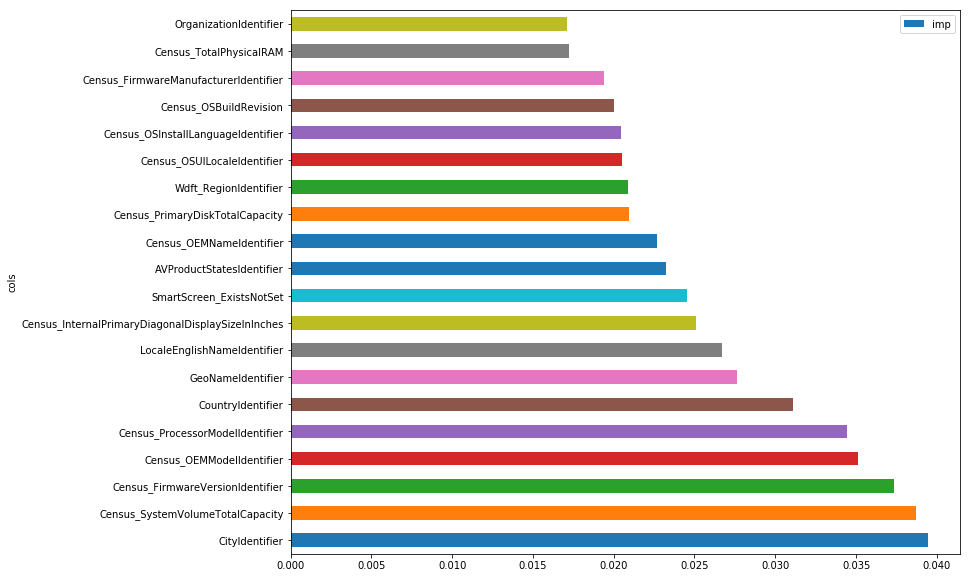

In [31]:
feat_importance[:20].plot('cols', 'imp', 'barh', figsize=(12,10))

In [33]:
y_test_vals = rf.predict(X_test)

In [35]:
roc_auc_score(y_test, y_test_vals)

0.6468011184266639

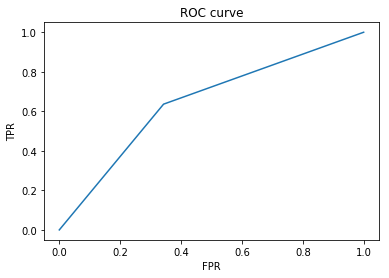

In [55]:
# skplt.metrics.plot_roc(y_test, y_test_vals)
# plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_vals)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# skplt.metrics.plot_roc_curve(y_test, y_test_vals)
# plt.show()